# First Metrics

In this notebook I will calculate some initial metric ideas for the observed heatwaves based on the output of the building model. 

## Things to achieve in this notebook:

[✔] Run the building simulation with the observed heatwave data

[✔] Calculate some initial metric values

[✔] See how well these match up with known heatwave severity 

[ ] Tweak parameters

[ ] Consider Thresholds

## Metric ideas to test:

- Something akin to the heatwave magnitude index (splits each heatwave into subheatwaves of 3 days each and finds the magnitudes of these, the magnitude of the heatwave is the sum of these)

- Rolling metrics - the value of the metric at any giving hour is a function of the preceding hours

- Cumulative metrics - Thresholds are set that correspond to varying levels of comfort, each hour is assigned value based on where it falls, these values are summed to give a heatwave score.

    - Consider negative scores to return back to a comfortable level - the heatwave score is the peak score?
    
**Note:** Within these consider different temperature indicators (apparent temperature?). Also where thresholds are concerned consider varying thresholds depending on time of day. 

### Import useful packages

In [18]:
import besos.eppy_funcs as ef
from besos.evaluator import EvaluatorEH, EvaluatorEP
from besos.problem import EPProblem, EHProblem, Problem
from besos.objectives import VariableReader, MeterReader
from besos import objectives
from besos.parameters import RangeParameter, CategoryParameter, Parameter, FieldSelector, GenericSelector
from besos import config
import pvlib
import numpy as np
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime
import metpy.calc

### Run the building with observed heatwaves

- Currently just one heatwave and building while I sort the code.

**Running the simulation:**

In [19]:
# Get the building model and specify the .epw
directory = './Building_models/5A_complete_data_sorted/no error/'
filename = 'SF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'#'MF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'
building = ef.get_building(directory + filename)

# Create dataframe to store results
column_names = ['02061982T', '02061982RH', '04071983T', '04071983RH', '15081995T', '15081995RH', 
                '20071989T', '20071989RH', '21071994T', '21071994RH', '23061976T', '23061976RH', 
                '23081990T', '23081990RH', '25071995T', '25071995RH', '26071983T', '26071983RH',
                '27061986T', '27061986RH', '31071990T', '31071990RH']
data_store = pd.DataFrame(columns = column_names)

# Loop over heatwaves with death data 

filenames = ['02061982', '04071983', '15081995', '20071989', '21071994', 
             '23061976', '23081990', '25071995', '26071983', '27061986', '31071990']

for filename_epw in filenames:
    epw_path = './observed_heatwaves/' + filename_epw + '.epw'
    
    # Set the cooling setpoint high so that HVAC system is not triggered during heatwave
    EPparameters = []
    EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                               selector=FieldSelector(class_name='Schedule:Compact',
                                                      object_name='cooling_sch',field_name='Field 4'),
                               value_descriptors=RangeParameter(min_val=20.1,max_val=40)))
    
    # Collect air temperature and humidity as outputs across all zones.
    EPobjectives = []
    outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
    for output in outputs:
        for u in [1,]:
            for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
                EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

    # Setting up the EnergyPlus simulation
    problem = EPProblem(EPparameters,EPobjectives)
    evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

    # Running a single simulation with cooling set point specified to be 40°C
    results = evaluator.eval_single([40])
    
    # Storing results (living space only)
    T = results[0]
    RH = results[3]
    
    data_store[filename_epw + 'T'] = T
    data_store[filename_epw + 'RH'] = RH

/home/user/.local/lib/python3.7/site-packages/besos/problem.py:152: RuntimeWarning: Duplicate names found. (duplicate, repetitions): [('Zone Mean Air Temperature', 3), ('Zone Air Relative Humidity', 3)]
Attempting to fix automatically
  f"Duplicate names found. (duplicate, repetitions): "
/home/user/.local/lib/python3.7/site-packages/besos/objectives.py:225: UserWarning: `time_series_values` is incomplete, and returns raw values, not time series values.
  "`time_series_values` is incomplete, and returns raw values, not time series values."


**Plotting:**

Extract the heatwave dates and mark these on each of the plots. The file name specifies the start date - remaining information should be made accessible from excess_deaths.csv.

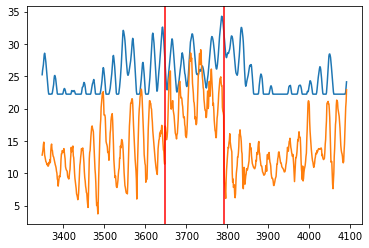

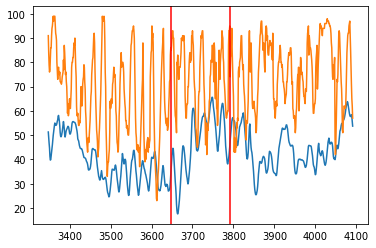

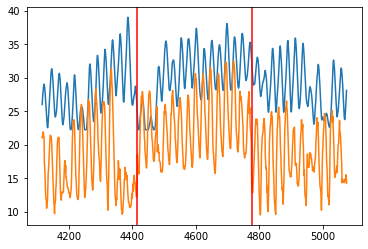

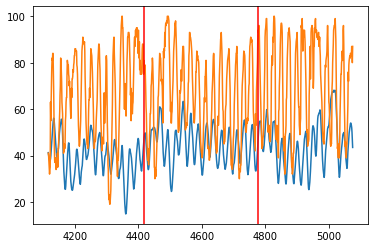

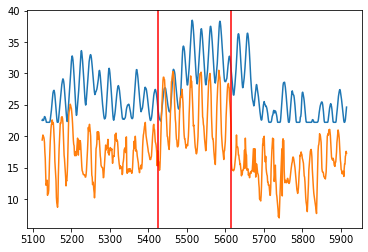

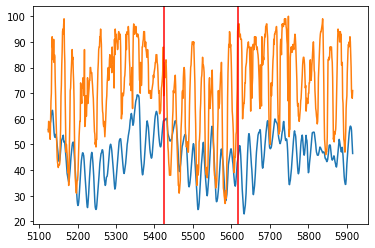

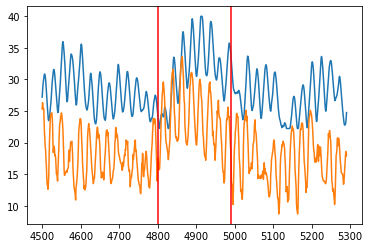

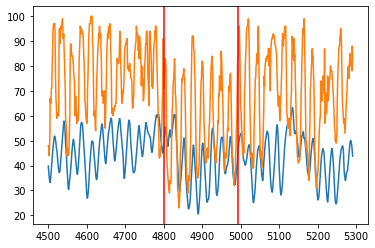

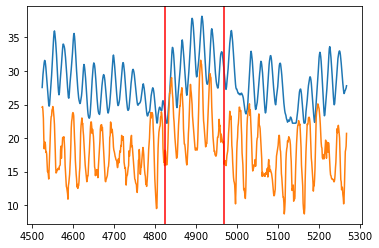

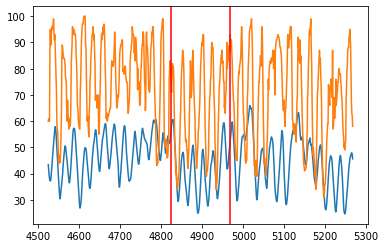

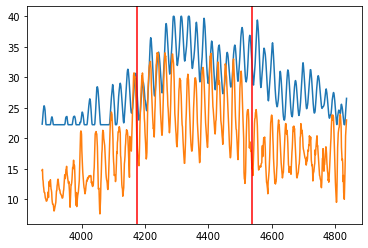

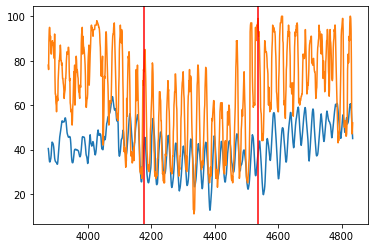

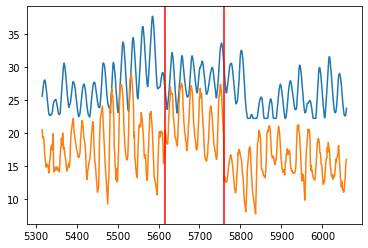

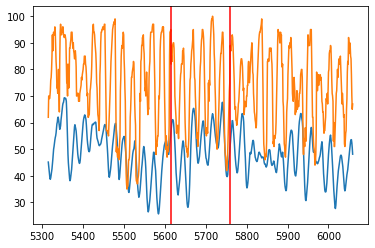

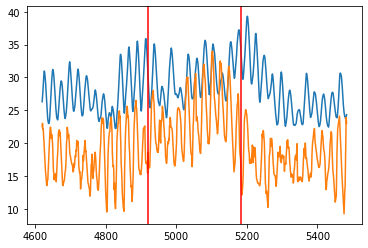

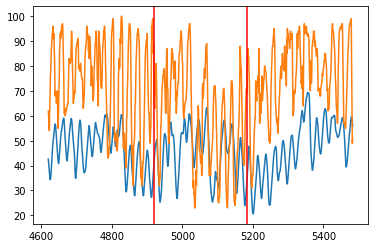

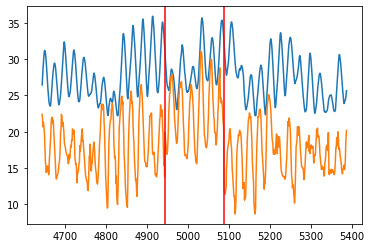

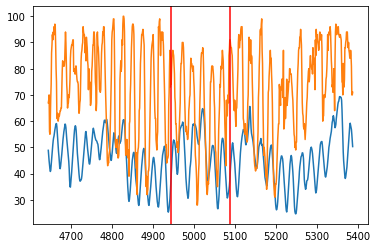

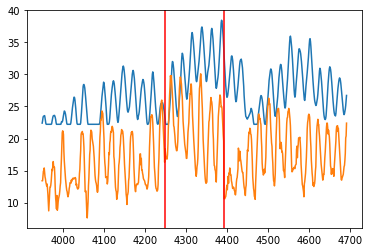

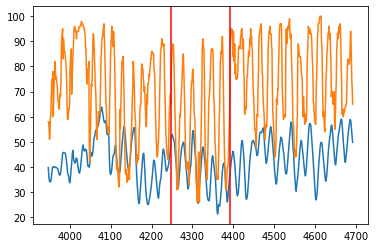

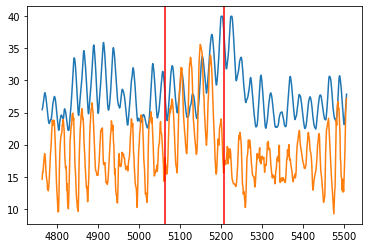

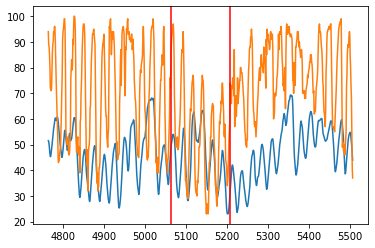

In [20]:
# Plot temperature and humidity for each heatwave marking on heatwave days
for filename_epw in filenames:
    epw_path = './observed_heatwaves/' + filename_epw + '.epw'
    # Extract start and end date
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(filename_epw):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
    # Find start and end hour
    start_date = datetime.strptime(dates[0], '%d/%m/%Y')
    start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
    start_hour = (start_day-1)*24

    end_date = datetime.strptime(dates[1], '%d/%m/%Y')
    end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
    end_hour = end_day*24
    
    limits = [start_hour-300, end_hour+300]
    
    df, metadata = pvlib.iotools.read_epw(epw_path)
    df = df.reset_index(drop=True)
    
    data_store[filename_epw + 'T'].iloc[limits[0]:limits[1]].plot()
    df['temp_air'].iloc[limits[0]:limits[1]].plot()
    plt.axvline(x=start_hour, c='r')
    plt.axvline(x=end_hour, c='r')
    plt.show()

    data_store[filename_epw + 'RH'].iloc[limits[0]:limits[1]].plot()
    df['relative_humidity'].iloc[limits[0]:limits[1]].plot()
    plt.axvline(x=start_hour, c='r')
    plt.axvline(x=end_hour, c='r')
    #plt.ylim([0,30])
    plt.show()



**Note:** Lag in the building response to temperature implies metric should be calculated beyond the heatwave itself?

### Metric calculation

Calculate some initial metrics to work out code and how the building responds to the heatwave.

I will start with some **initial plots** to look at if various heatwave attributes are informative.

In [4]:
column_names = ['heatwave', 
                'peak_intensity_T', 'mean_intensity_T', 'minimum_intensity_T', 
                'peak_intensity_HI', 'mean_intensity_HI', 'minimum_intensity_HI', 
                'duration', 'deaths']

df_attributes = pd.DataFrame(columns = column_names)

j = 0
for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            duration = excess_deaths.iloc[i][3]
            deaths = excess_deaths.iloc[i][4]
            
    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour]
    
    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH
    HI = (HIF-32)*5/9
    
    row = [heatwave,
          max(T), np.mean(T), min(T), 
          max(HI), np.mean(HI), min(HI), 
          float(duration), float(deaths)]
    
    df_attributes.loc[j] = row
    j = j + 1


In [5]:
df_attributes

heatwave  peak_intensity_T  mean_intensity_T  minimum_intensity_T  \
0   02061982         32.787350         26.251626            22.219994   
1   04071983         32.785166         26.251314            22.219994   
2   15081995         32.786078         26.251197            22.219994   
3   20071989         32.784964         26.263348            22.219994   
4   21071994         32.785654         26.252845            22.219994   
5   23061976         32.786780         26.251330            22.219994   
6   23081990         32.786078         26.251197            22.219994   
7   25071995         39.314769         31.812181            26.422005   
8   26071983         35.361639         28.332574            22.219996   
9   27061986         32.785837         26.251447            22.219994   
10  31071990         40.000003         29.796601            23.733954   

    peak_intensity_HI  mean_intensity_HI  minimum_intensity_HI  duration  \
0           31.302044          26.841971             24.272811       6.0   
1           31.299935          26.841761             24.273302      15.0   
2           31.300803          26.841681             24.273003       8.0   
3           31.299743          26.850446             24.273339       8.0   
4           31.300413          26.842898             24.273226       6.0   
5           31.301483          26.841752             24.272841      15.0   
6           31.300803          26.841681             24.273003       6.0   
7           38.787412          32.185862             27.010903      11.0   
8           35.696791          28.869495             24.867076       6.0   
9           31.300587          26.841870             24.273317       6.0   
10          40.568010          30.152056             25.217000       6.0   

    deaths  
0     0.03  
1    11.28  
2    -3.03  
3    10.96  
4    -0.19  
5    30.69  
6     5.39  
7     7.13  
8     4.46  
9     3.54  
10   16.82

**Deaths vs Peak Intensity**

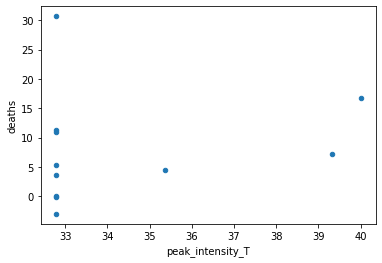

In [6]:
df_attributes.plot('peak_intensity_T', 'deaths', 'scatter')

**Deaths vs Average Intensity**

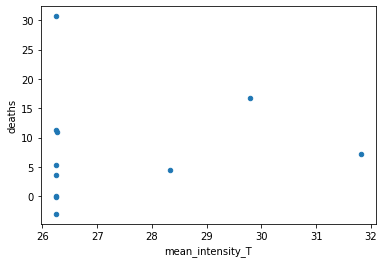

In [7]:
df_attributes.plot('mean_intensity_T', 'deaths', 'scatter')

**Deaths vs Min Intensity**

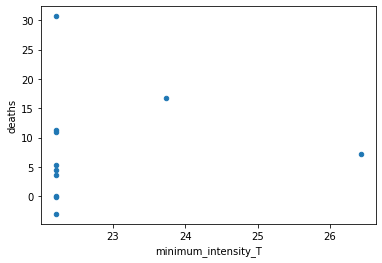

In [8]:
df_attributes.plot('minimum_intensity_T', 'deaths', 'scatter')

**Deaths vs Duration**

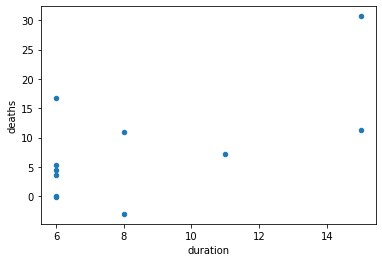

In [9]:
df_attributes.plot('duration', 'deaths', 'scatter')

**Deaths vs duration boosted intensity**

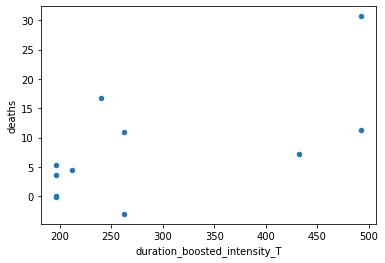

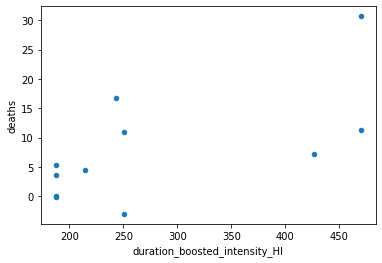

In [10]:
df_attributes['duration_boosted_intensity_T'] = df_attributes['peak_intensity_T']*df_attributes['duration']
df_attributes.plot('duration_boosted_intensity_T', 'deaths', 'scatter')
df_attributes['duration_boosted_intensity_HI'] = df_attributes['peak_intensity_HI']*df_attributes['duration']
df_attributes.plot('duration_boosted_intensity_HI', 'deaths', 'scatter')

**Deaths vs Amplitude**

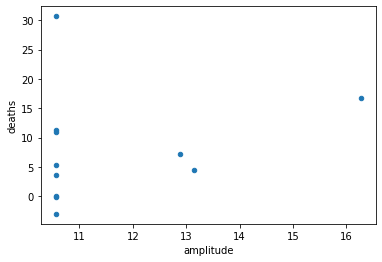

In [11]:
df_attributes['amplitude'] = df_attributes['peak_intensity_T']-df_attributes['minimum_intensity_T']

df_attributes.plot('amplitude', 'deaths', 'scatter')

We can see the most deadly heatwave is not captured by intensity alone but by duration. The overall trend in number of deaths is captured best by duration boosted intensity. This is likely due to the deaths being spread over a longer period - it may also be sensible to consider duration normalised deaths e.g. an estimate of daily deaths.

In [12]:
df_attributes.corr(method='pearson')['deaths']

peak_intensity_T                 0.190116
mean_intensity_T                 0.110332
minimum_intensity_T              0.082118
peak_intensity_HI                0.186032
mean_intensity_HI                0.105433
minimum_intensity_HI             0.052441
duration                         0.631607
deaths                           1.000000
duration_boosted_intensity_T     0.637513
duration_boosted_intensity_HI    0.641759
amplitude                        0.227183
Name: deaths, dtype: float64

In [13]:
df_attributes.corr(method='spearman')['deaths']

peak_intensity_T                 0.150342
mean_intensity_T                 0.214124
minimum_intensity_T              0.041002
peak_intensity_HI                0.150342
mean_intensity_HI                0.195900
minimum_intensity_HI             0.287017
duration                         0.493399
deaths                           1.000000
duration_boosted_intensity_T     0.609091
duration_boosted_intensity_HI    0.609091
amplitude                        0.132119
Name: deaths, dtype: float64

### With deaths normalised over time

In [14]:
df_attributes['daily_deaths'] = df_attributes['deaths']/df_attributes['duration']

**Deaths vs Intensity**

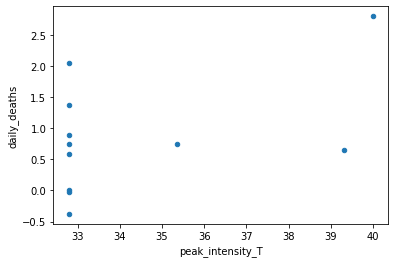

In [15]:
df_attributes.plot('peak_intensity_T', 'daily_deaths', 'scatter')

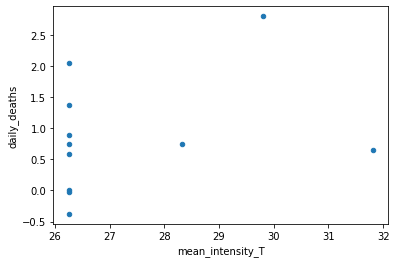

In [16]:
df_attributes.plot('mean_intensity_T', 'daily_deaths', 'scatter')

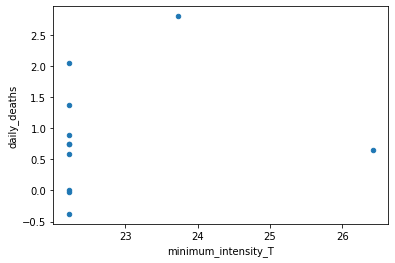

In [17]:
df_attributes.plot('minimum_intensity_T', 'daily_deaths', 'scatter')

**Deaths vs Duration**

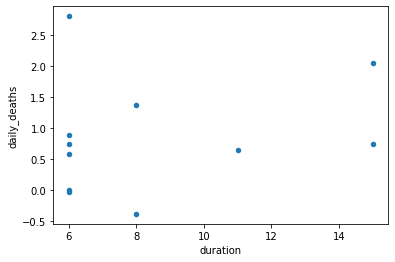

In [18]:
df_attributes.plot('duration', 'daily_deaths', 'scatter')

**Deaths vs Duration Boosted Intensity**

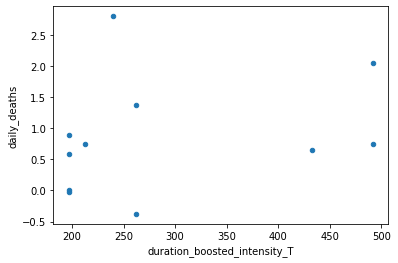

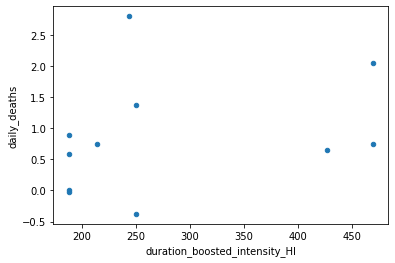

In [63]:
df_attributes['duration_boosted_intensity_T'] = df_attributes['peak_intensity_T']*df_attributes['duration']
df_attributes.plot('duration_boosted_intensity_T', 'daily_deaths', 'scatter')
df_attributes['duration_boosted_intensity_HI'] = df_attributes['peak_intensity_HI']*df_attributes['duration']
df_attributes.plot('duration_boosted_intensity_HI', 'daily_deaths', 'scatter')

**Deaths vs Amplitude**

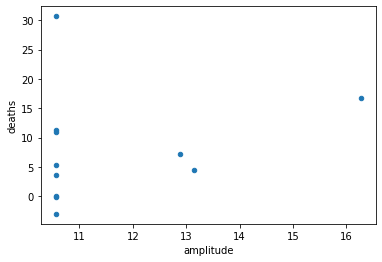

In [20]:
df_attributes['amplitude'] = df_attributes['peak_intensity_T']-df_attributes['minimum_intensity_T']

df_attributes.plot('amplitude', 'deaths', 'scatter')

In [21]:
df_attributes.corr(method='pearson')['daily_deaths']

peak_intensity_T                 0.478546
mean_intensity_T                 0.309241
minimum_intensity_T              0.169955
peak_intensity_HI                0.493513
mean_intensity_HI                0.299727
minimum_intensity_HI             0.152185
duration                         0.216400
deaths                           0.844531
duration_boosted_intensity_T     0.269964
duration_boosted_intensity_HI    0.290634
amplitude                        0.597694
daily_deaths                     1.000000
Name: daily_deaths, dtype: float64

In [22]:
df_attributes.corr(method='spearman')['daily_deaths']

peak_intensity_T                 0.159454
mean_intensity_T                 0.195900
minimum_intensity_T              0.095672
peak_intensity_HI                0.159454
mean_intensity_HI                0.168565
minimum_intensity_HI             0.268793
duration                         0.214305
deaths                           0.927273
duration_boosted_intensity_T     0.381818
duration_boosted_intensity_HI    0.381818
amplitude                        0.168565
daily_deaths                     1.000000
Name: daily_deaths, dtype: float64

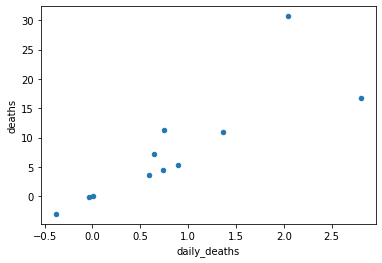

In [23]:
## Just checking they are different things
df_attributes.plot('daily_deaths', 'deaths', 'scatter')

#### Set up metric store

In [36]:
metrics = ['heatwave', 'deaths', 'duration_boosted_intensity', 'cumulativeNEG', 'cumulative0', 'HWMI2', 'HWMI3']
df_metrics = pd.DataFrame(columns = metrics)

df_metrics['heatwave'] = df_attributes['heatwave']
df_metrics['deaths'] = df_attributes['deaths']
df_metrics['duration_boosted_intensity'] = df_attributes['duration_boosted_intensity_HI']

#### Cumulative metric

The heat index has existing thresholds, defined below. If a value is assigned to each we can then record a cumulative heatwave score.

- <27 = neutral (-1)

- 27 - 32 = caution (1)

- 33 - 39 = extreme caution (2)

- 40 - 52 = danger (3)

- 52 - 60 = extreme danger (4)

- 60+ (I guess this is unlikely)

02061982


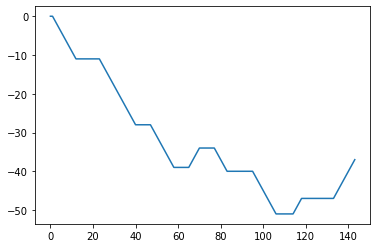

Excess deaths: 0.03
04071983


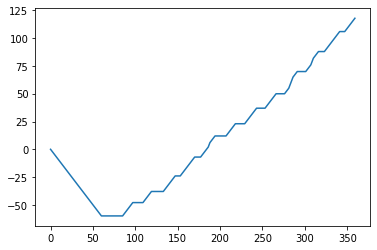

Excess deaths: 11.28
15081995


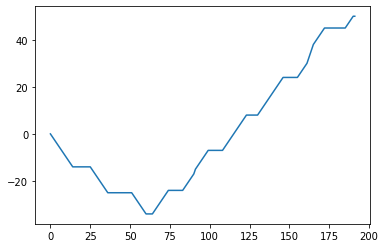

Excess deaths: -3.03
20071989


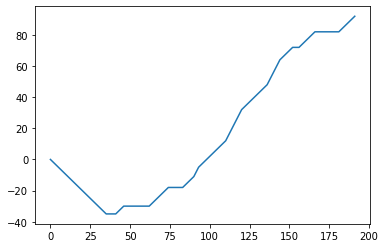

Excess deaths: 10.96
21071994


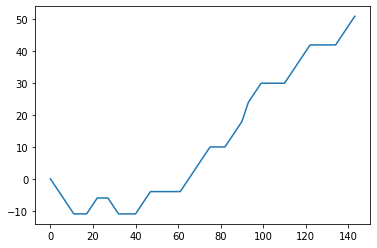

Excess deaths: -0.19
23061976


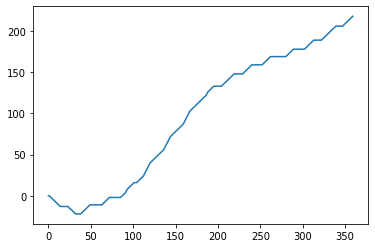

Excess deaths: 30.69
23081990


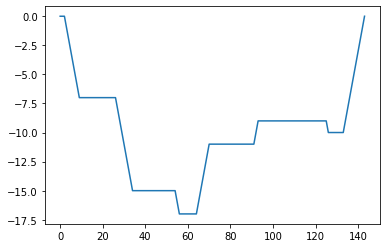

Excess deaths: 5.39
25071995


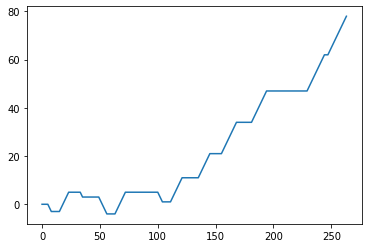

Excess deaths: 7.13
26071983


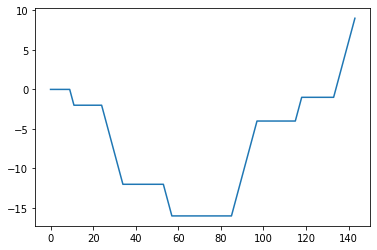

Excess deaths: 4.46
27061986


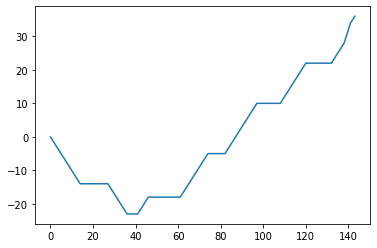

Excess deaths: 3.54
31071990


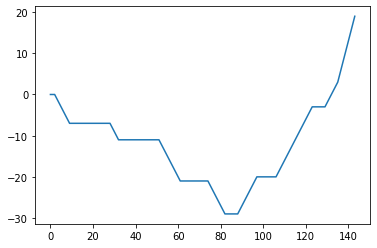

Excess deaths: 16.82


In [37]:
List = np.zeros(len(filenames))
j = 0
for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24

            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24

    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour]
    D = deaths

    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

    HI = (HIF-32)*5/9

    HI_vals = np.zeros(len(HI))
    i = 0
    for value in HI:
        if round(value)<27:
            score = -1
        elif round(value)<32:
            score = 0
        elif round(value)<39:
            score = 1
        elif round(value)<52:
            score = 2
        else:
            score = 3

        HI_vals[i] = score
        i = i+1

    HW_score = np.zeros(len(HI_vals))
    for i in range(len(HI_vals)):
        HW_score[i] = sum(HI_vals[0:i])
    
    print(heatwave)
    plt.plot(HW_score)
    plt.show()
    print('Excess deaths:', D)
    
    List[j] = max(HW_score)
    j = j + 1

df_metrics['cumulativeNEG'] = List

Fiddle with values when working with all the heatwaves to fit severity.

02061982


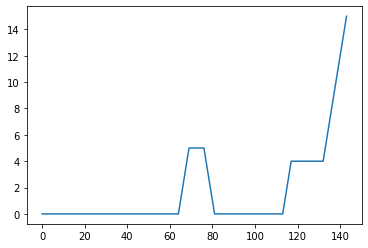

Excess deaths: 0.03
04071983


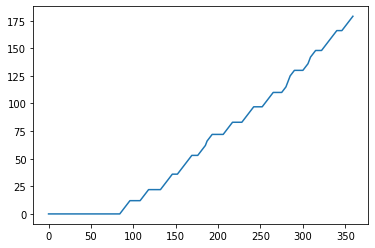

Excess deaths: 11.28
15081995


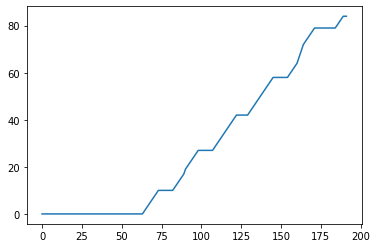

Excess deaths: -3.03
20071989


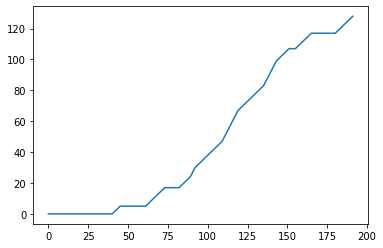

Excess deaths: 10.96
21071994


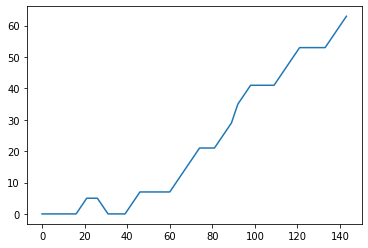

Excess deaths: -0.19
23061976


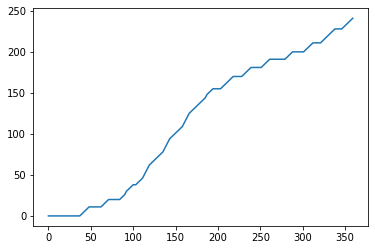

Excess deaths: 30.69
23081990


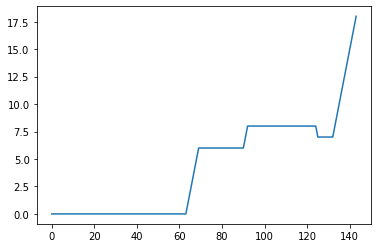

Excess deaths: 5.39
25071995


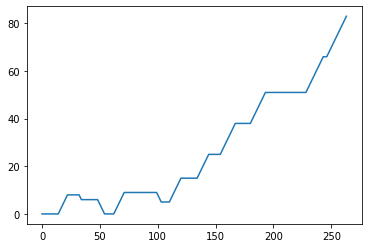

Excess deaths: 7.13
26071983


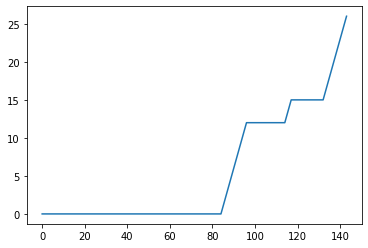

Excess deaths: 4.46
27061986


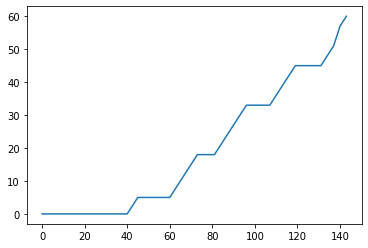

Excess deaths: 3.54
31071990


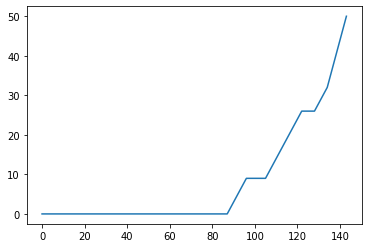

Excess deaths: 16.82


In [38]:
List = np.zeros(len(filenames))
j = 0
for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24

            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24

    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour]
    D = deaths

    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

    HI = (HIF-32)*5/9

    HI_vals = np.zeros(len(HI))
    i = 0
    for value in HI:
        if round(value)<27:
            score = -1
        elif round(value)<32:
            score = 0
        elif round(value)<39:
            score = 1
        elif round(value)<52:
            score = 2
        else:
            score = 3

        HI_vals[i] = score
        i = i+1

    HW_score = np.zeros(len(HI_vals))
    for i in range(len(HI_vals)):
        HW_score[i] = max([sum(HI_vals[0:i]), HW_score[i-1] + HI_vals[i], 0])
    
    print(heatwave)
    plt.plot(HW_score)
    plt.show()
    print('Excess deaths:', D)
    
    List[j] = max(HW_score)
    j = j + 1

df_metrics['cumulative0'] = List

#### HWMI inspired

02061982


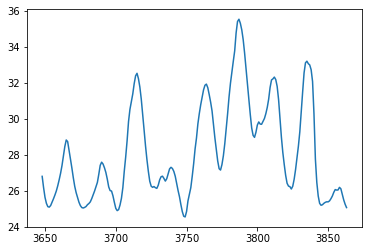

139.6812124350589
0.03
04071983


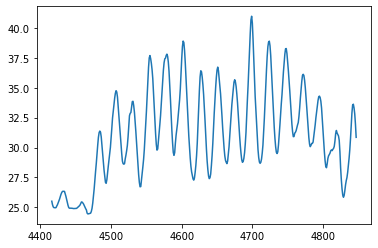

280.56897741052234
11.28
15081995


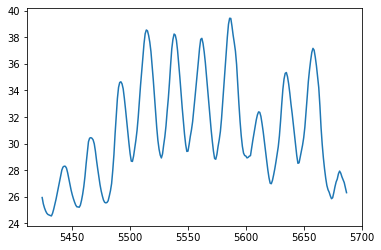

183.53876031768908
-3.03
20071989


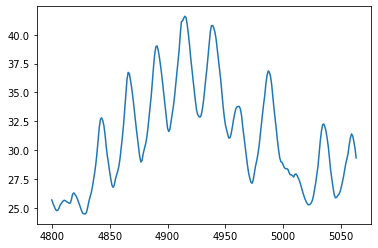

185.03215837260802
10.96
21071994


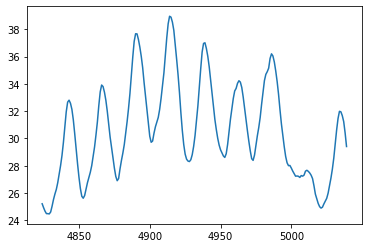

151.74499644998025
-0.19
23061976


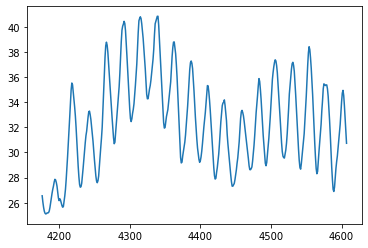

292.67046680976546
30.69
23081990


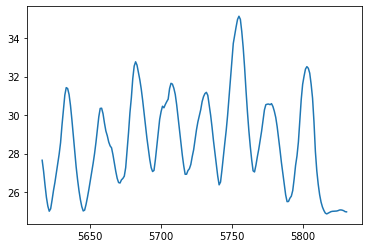

141.75643212851082
5.39
25071995


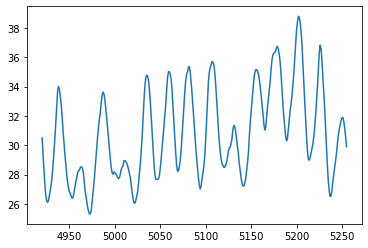

215.6354717191145
7.13
26071983


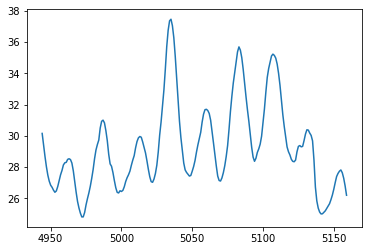

144.98671020704856
4.46
27061986


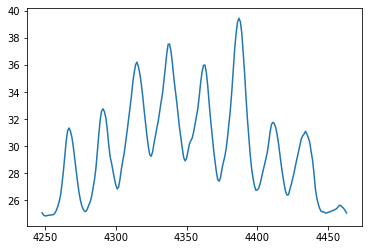

147.07619642453705
3.54
31071990


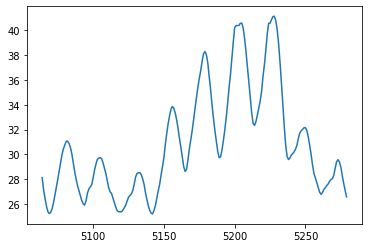

152.62421160145172
16.82


In [39]:
List = np.zeros(len(filenames))
j = 0

for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24

            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24

    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour+72]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour+72]
    D = deaths

    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

    HI = (HIF-32)*5/9
    print(heatwave)
    plt.plot(HI)
    plt.show()

    # Split in to 2 day chunks and calculate the mean HI value
    # Sum up over duration
    means = 0
    HI = np.asarray(HI)
    for i in range(0, len(HI), 48):
        chunk = HI[i: i+48]
        chunk_mean = np.mean(chunk)
        means = means + chunk_mean
    
    print(means)
    print(D)

        
    List[j] = means
    j = j + 1

df_metrics['HWMI2'] = List

02061982


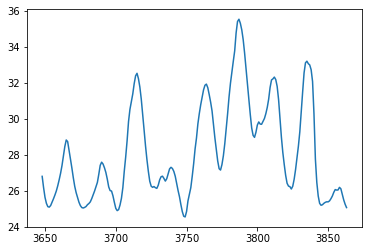

84.48085574128044
0.03
04071983


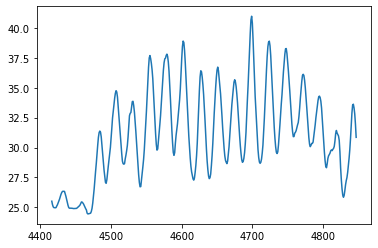

187.04598494034823
11.28
15081995


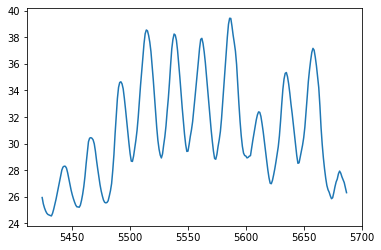

123.21874186141781
-3.03
20071989


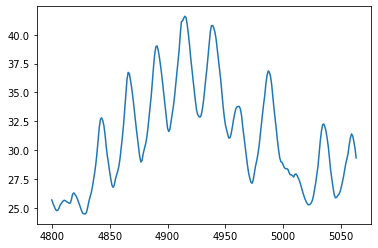

123.31623113626596
10.96
21071994


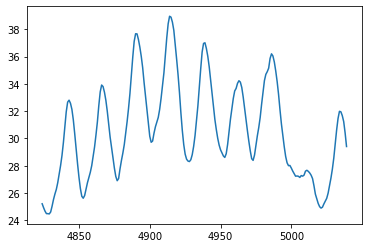

91.87600508457697
-0.19
23061976


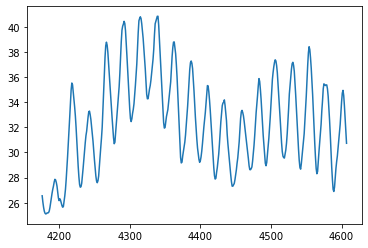

195.11364453984362
30.69
23081990


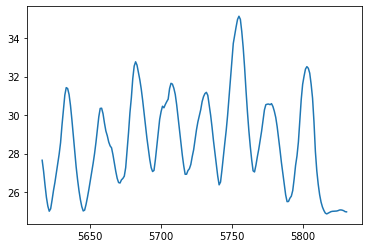

85.99313841993185
5.39
25071995


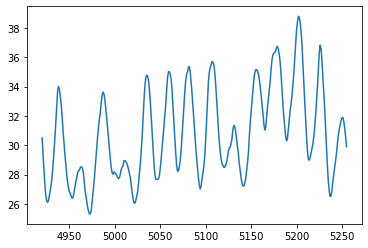

154.07706614964886
7.13
26071983


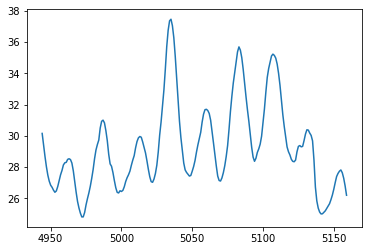

87.87452585219395
4.46
27061986


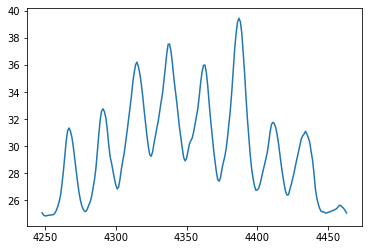

89.54133064431129
3.54
31071990


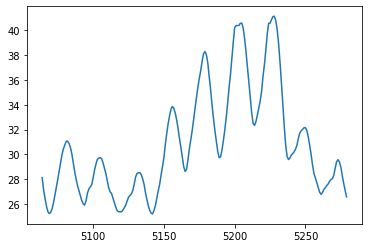

92.4425515463891
16.82


In [40]:
List = np.zeros(len(filenames))
j = 0

for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24

            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24

    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour+72]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour+72]
    D = deaths

    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

    HI = (HIF-32)*5/9
    print(heatwave)
    plt.plot(HI)
    plt.show()

    # Split in to 2 day chunks and calculate the mean HI value
    # Sum up over duration
    means = 0
    HI = np.asarray(HI)
    for i in range(0, len(HI), 72):
        chunk = HI[i: i+72]
        chunk_mean = np.mean(chunk)
        means = means + chunk_mean
    
    print(means)
    print(D)

        
    List[j] = means
    j = j + 1

df_metrics['HWMI3'] = List

In [41]:
df_metrics

heatwave  deaths  duration_boosted_intensity  cumulativeNEG  cumulative0  \
0   02061982    0.03                  187.812266            0.0         15.0   
1   04071983   11.28                  469.499032          118.0        179.0   
2   15081995   -3.03                  250.406423           50.0         84.0   
3   20071989   10.96                  250.397946           92.0        128.0   
4   21071994   -0.19                  187.802479           51.0         63.0   
5   23061976   30.69                  469.522248          218.0        241.0   
6   23081990    5.39                  187.804817            0.0         18.0   
7   25071995    7.13                  426.661529           78.0         83.0   
8   26071983    4.46                  214.180746            9.0         26.0   
9   27061986    3.54                  187.803521           36.0         60.0   
10  31071990   16.82                  243.408062           19.0         50.0   

         HWMI2       HWMI3  
0   139.681212   84.480856  
1   280.568977  187.045985  
2   183.538760  123.218742  
3   185.032158  123.316231  
4   151.744996   91.876005  
5   292.670467  195.113645  
6   141.756432   85.993138  
7   215.635472  154.077066  
8   144.986710   87.874526  
9   147.076196   89.541331  
10  152.624212   92.442552

In [42]:
df_metrics.corr(method='pearson')['deaths']

deaths                        1.000000
duration_boosted_intensity    0.641759
cumulativeNEG                 0.747256
cumulative0                   0.729148
HWMI2                         0.666713
HWMI3                         0.627271
Name: deaths, dtype: float64

In [44]:
df_metrics.corr(method='spearman')['deaths']

deaths                        1.000000
duration_boosted_intensity    0.609091
cumulativeNEG                 0.469250
cumulative0                   0.418182
HWMI2                         0.590909
HWMI3                         0.590909
Name: deaths, dtype: float64

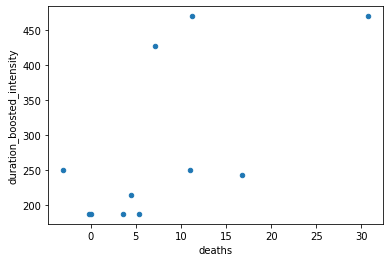

In [47]:
df_metrics.plot('deaths', 'duration_boosted_intensity', 'scatter')

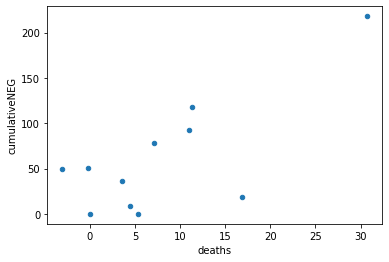

In [48]:
df_metrics.plot('deaths', 'cumulativeNEG', 'scatter')

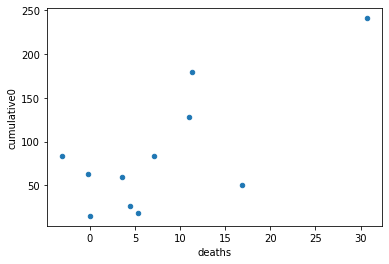

In [49]:
df_metrics.plot('deaths', 'cumulative0', 'scatter')

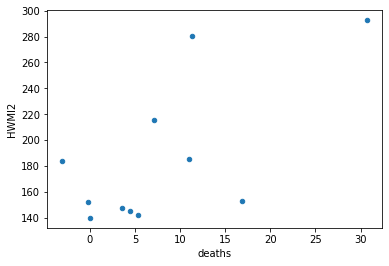

In [50]:
df_metrics.plot('deaths', 'HWMI2', 'scatter')

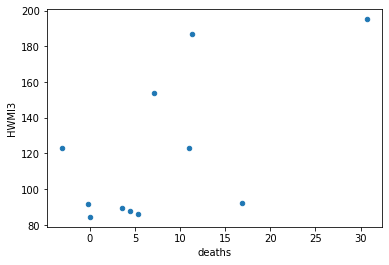

In [52]:
df_metrics.plot('deaths', 'HWMI3', 'scatter')

Visually and in terms of correlation the cumulative metrics seem to work best. The heatwave that is attributed to around a 16% increase in excess deaths scores consistently lower than it probably should. We look at this in more detail.

In [58]:
print(df_attributes.iloc[10])

heatwave                           31071990
peak_intensity_T                  40.000003
mean_intensity_T                  29.796601
minimum_intensity_T               23.733954
peak_intensity_HI                  40.56801
mean_intensity_HI                 30.152056
minimum_intensity_HI                 25.217
duration                                6.0
deaths                                16.82
duration_boosted_intensity_T     240.000016
duration_boosted_intensity_HI    243.408062
amplitude                         16.266048
daily_deaths                       2.803333
Name: 10, dtype: object


In [61]:
print(df_metrics.iloc[10])

heatwave                        31071990
deaths                             16.82
duration_boosted_intensity    243.408062
cumulativeNEG                       19.0
cumulative0                         50.0
HWMI2                         152.624212
HWMI3                          92.442552
Name: 10, dtype: object


This heatwave is the most intense but only average in length compared to the hot spells considered. Perhaps normalising intensity will help to make these differences more distinct. 

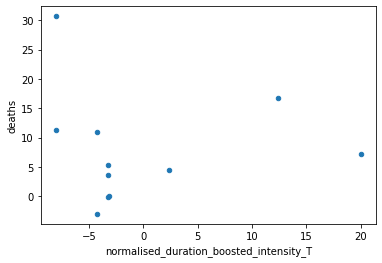

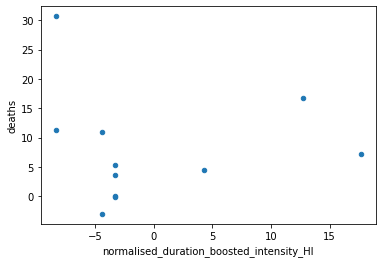

In [77]:
df_attributes['normalised_temperature_T']=\
                    (df_attributes['peak_intensity_T']-df_attributes['peak_intensity_T'].mean())\
                    /df_attributes['peak_intensity_T'].std()
df_attributes['normalised_temperature_HI']=\
                    (df_attributes['peak_intensity_HI']-df_attributes['peak_intensity_HI'].mean())\
                    /df_attributes['peak_intensity_HI'].std()

df_attributes['normalised_duration_boosted_intensity_T'] = df_attributes['normalised_temperature_T']*df_attributes['duration']
df_attributes.plot('normalised_duration_boosted_intensity_T', 'deaths', 'scatter')
df_attributes['normalised_duration_boosted_intensity_HI'] = df_attributes['normalised_temperature_HI']*df_attributes['duration']
df_attributes.plot('normalised_duration_boosted_intensity_HI', 'deaths', 'scatter')

**Notes:** This captures the severity of the heatwave in question but loses another due to negative temperature anomaly. Set between 0 and 1?

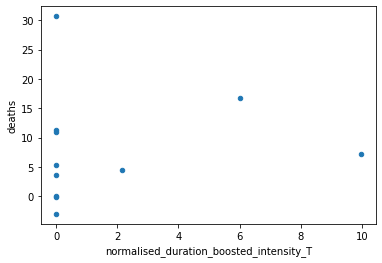

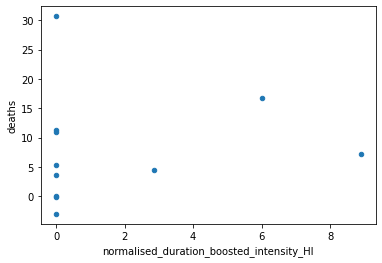

In [78]:
df_attributes['normalised_temperature_T']=(df_attributes['peak_intensity_T']-df_attributes['peak_intensity_T'].min())\
                                        /(df_attributes['peak_intensity_T'].max()-df_attributes['peak_intensity_T'].min())
df_attributes['normalised_temperature_HI']=(df_attributes['peak_intensity_HI']-df_attributes['peak_intensity_HI'].min())\
                                        /(df_attributes['peak_intensity_HI'].max()-df_attributes['peak_intensity_HI'].min())

df_attributes['normalised_duration_boosted_intensity_T'] = df_attributes['normalised_temperature_T']*df_attributes['duration']
df_attributes.plot('normalised_duration_boosted_intensity_T', 'deaths', 'scatter')
df_attributes['normalised_duration_boosted_intensity_HI'] = df_attributes['normalised_temperature_HI']*df_attributes['duration']
df_attributes.plot('normalised_duration_boosted_intensity_HI', 'deaths', 'scatter')

Now we have zero values which is just as bad. We add one to each as a quick fix.

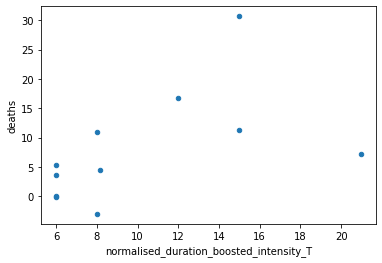

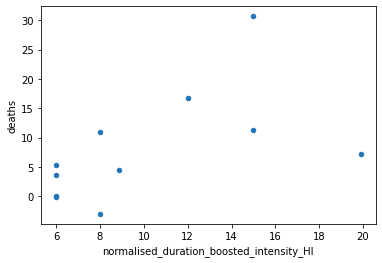

In [79]:
df_attributes['normalised_temperature_T']=(df_attributes['peak_intensity_T']-df_attributes['peak_intensity_T'].min())\
                                        /(df_attributes['peak_intensity_T'].max()-df_attributes['peak_intensity_T'].min()) + 1
df_attributes['normalised_temperature_HI']=(df_attributes['peak_intensity_HI']-df_attributes['peak_intensity_HI'].min())\
                                        /(df_attributes['peak_intensity_HI'].max()-df_attributes['peak_intensity_HI'].min()) + 1

df_attributes['normalised_duration_boosted_intensity_T'] = df_attributes['normalised_temperature_T']*df_attributes['duration']
df_attributes.plot('normalised_duration_boosted_intensity_T', 'deaths', 'scatter')
df_attributes['normalised_duration_boosted_intensity_HI'] = df_attributes['normalised_temperature_HI']*df_attributes['duration']
df_attributes.plot('normalised_duration_boosted_intensity_HI', 'deaths', 'scatter')

This does a decent job - worth considering other approaches - maybe degrees above the heatwave threshold?

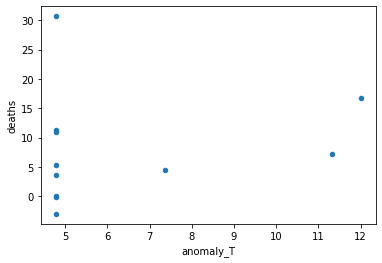

In [81]:
df_attributes['anomaly_T']=df_attributes['peak_intensity_T'] - 28
df_attributes['duration_boosted_anomaly_T'] = df_attributes['anomaly_T']*df_attributes['duration']
df_attributes.plot('anomaly_T', 'deaths', 'scatter')

More thought needed - maybe some kind of overall magnitude booster as part of the cumulative metric - or just more levels (some room for tuning here)

### New metrics

A couple of new metrics similar to the cumulative metric but one a daily and bi-daily timeframe

**Daily**

02061982


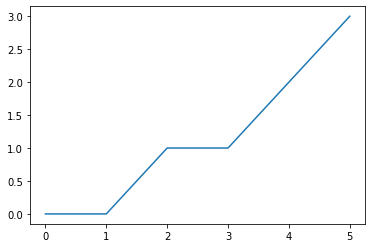

Excess deaths: 0.03
04071983


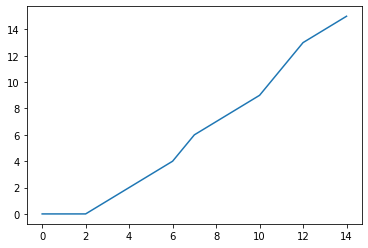

Excess deaths: 11.28
15081995


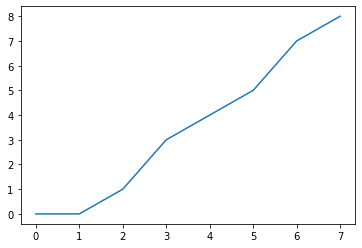

Excess deaths: -3.03
20071989


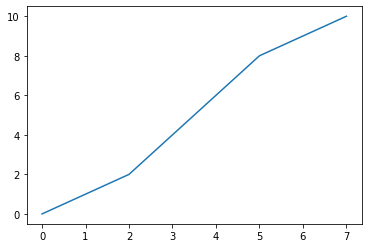

Excess deaths: 10.96
21071994


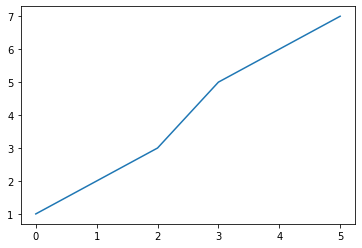

Excess deaths: -0.19
23061976


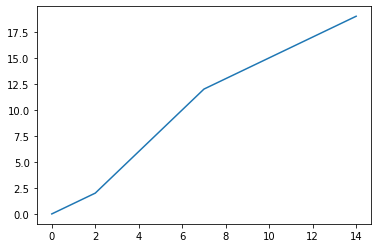

Excess deaths: 30.69
23081990


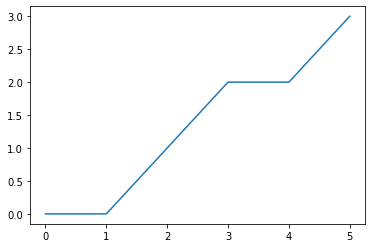

Excess deaths: 5.39
25071995


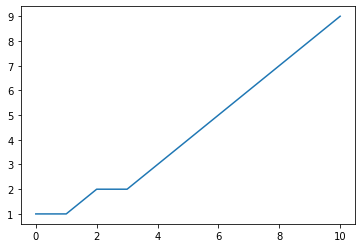

Excess deaths: 7.13
26071983


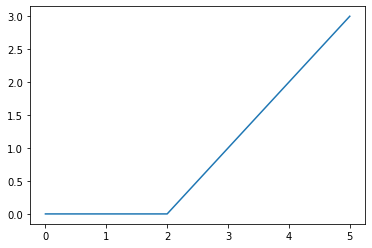

Excess deaths: 4.46
27061986


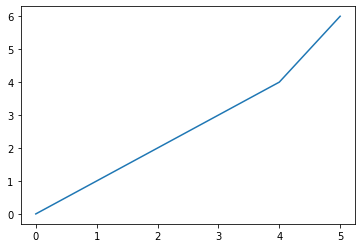

Excess deaths: 3.54
31071990


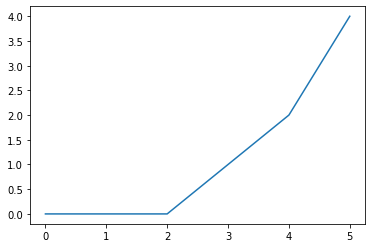

Excess deaths: 16.82


In [27]:
List = np.zeros(len(filenames))
j = 0
for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24

            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24

    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour]
    D = deaths

    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

    HI = (HIF-32)*5/9

    HI_vals = np.zeros(int(len(HI)/24))
    for i in range(int(len(HI)/24)):
        day = HI[i*24:i*24+24]
        max_day = max(day)
        if round(max_day)<27:
            score = -1
        elif round(max_day)<32:
            score = 0
        elif round(max_day)<39:
            score = 1
        elif round(max_day)<52:
            score = 2
        else:
            score = 3

        HI_vals[i] = score

    HW_score = np.zeros(len(HI_vals))
    for i in range(len(HI_vals)):
        HW_score[i] = max([sum(HI_vals[0:i]), HW_score[i-1] + HI_vals[i], 0])
    
    print(heatwave)
    plt.plot(HW_score)
    plt.show()
    print('Excess deaths:', D)
    
    List[j] = max(HW_score)
    j = j + 1


**Bi-Daily**

02061982


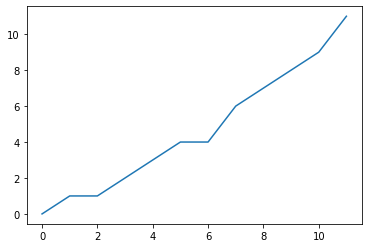

Excess deaths: 0.03
04071983


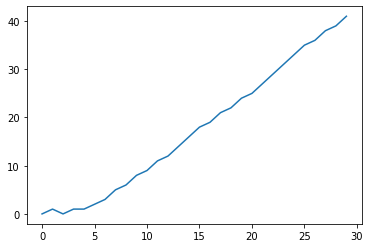

Excess deaths: 11.28
15081995


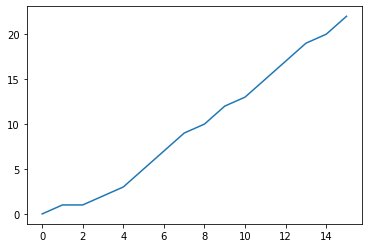

Excess deaths: -3.03
20071989


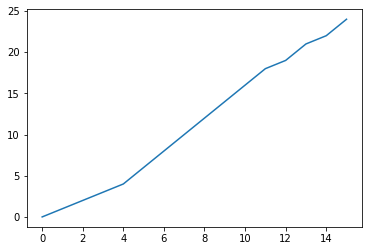

Excess deaths: 10.96
21071994


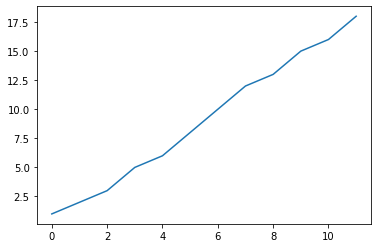

Excess deaths: -0.19
23061976


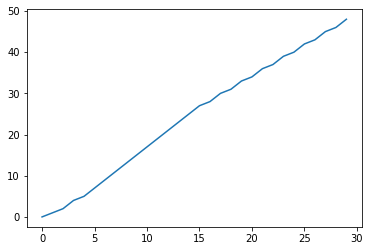

Excess deaths: 30.69
23081990


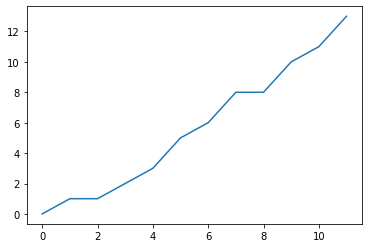

Excess deaths: 5.39
25071995


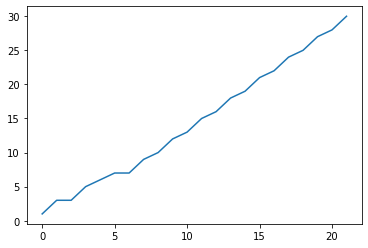

Excess deaths: 7.13
26071983


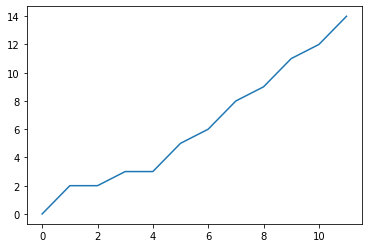

Excess deaths: 4.46
27061986


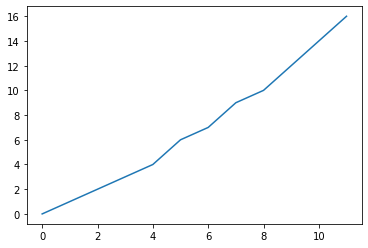

Excess deaths: 3.54
31071990


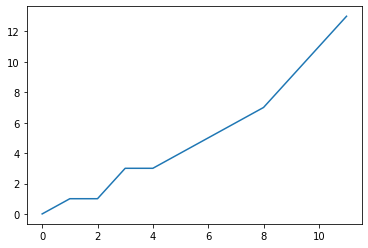

Excess deaths: 16.82


In [39]:
List = np.zeros(len(filenames))
j = 0
for heatwave in filenames:
    # Attibutes
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(heatwave):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24

            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24

    ## Extract data of interest:
    # Building temperature during the heatwave (Living only)
    T = data_store[heatwave + 'T'].iloc[start_hour:end_hour]
    TF = (T*9/5) + 32
    RH = data_store[heatwave + 'RH'].iloc[start_hour:end_hour]
    D = deaths

    # Calculate heat index value
    HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

    HI = (HIF-32)*5/9

    HI_vals = np.zeros(int(len(HI)/24)*2)
    for i in range(int(len(HI)/24)):
        day = HI[i*24:i*24+24]
        max_day = max(day)
        min_day = min(day)
        if round(max_day)<27:
            score = -1
        elif round(max_day)<32:
            score = 0
        elif round(max_day)<39:
            score = 1
        elif round(max_day)<52:
            score = 2
        else:
            score = 3
        # Check for tropical night - change cooling set point for night!!
        if round(min_day) > 25:
            night_score = 2
        elif round(min_day) > 20:
            night_score = 1
        else:
            night_score = -1

        HI_vals[i*2] = score
        HI_vals[i*2+1] = night_score


    HW_score = np.zeros(len(HI_vals))
    for i in range(len(HI_vals)):
        HW_score[i] = max([sum(HI_vals[0:i]), HW_score[i-1] + HI_vals[i], 0])
    
    print(heatwave)
    plt.plot(HW_score)
    plt.show()
    print('Excess deaths:', D)
    
    List[j] = max(HW_score)
    j = j + 1


## Looking at some typical .epws

/home/user/.local/lib/python3.7/site-packages/besos/problem.py:152: RuntimeWarning: Duplicate names found. (duplicate, repetitions): [('Zone Mean Air Temperature', 3), ('Zone Air Relative Humidity', 3)]
Attempting to fix automatically
  f"Duplicate names found. (duplicate, repetitions): "
/home/user/.local/lib/python3.7/site-packages/besos/objectives.py:225: UserWarning: `time_series_values` is incomplete, and returns raw values, not time series values.
  "`time_series_values` is incomplete, and returns raw values, not time series values."


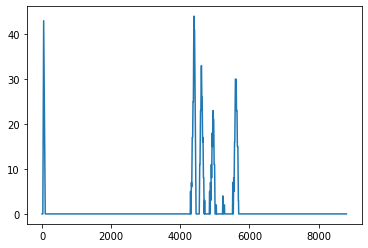

44.0


In [10]:
# Get the building model and specify the .epw
directory = './Building_models/5A_complete_data_sorted/no error/'
filename = 'SF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'#'MF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'
building = ef.get_building(directory + filename)

epw_path = 'GBR_London.Gatwick.037760_IWEC.epw'
    
# Set the cooling setpoint high so that HVAC system is not triggered during heatwave
EPparameters = []
EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                           selector=FieldSelector(class_name='Schedule:Compact',
                                                  object_name='cooling_sch',field_name='Field 4'),
                           value_descriptors=RangeParameter(min_val=20.1,max_val=40)))

# Collect air temperature and humidity as outputs across all zones.
EPobjectives = []
outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
for output in outputs:
    for u in [1,]:
        for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
            EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

# Setting up the EnergyPlus simulation
problem = EPProblem(EPparameters,EPobjectives)
evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

# Running a single simulation with cooling set point specified to be 40°C
results = evaluator.eval_single([40])

# Storing results (living space only)
T = results[0]
TF = T*9/5 + 32
RH = results[3]
# Calculate heat index
HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

HI = (HIF-32)*5/9

# Calculate cumulative0
HI_vals = np.zeros(len(HI))
i = 0
for value in HI:
    if round(value)<27:
        score = -1
    elif round(value)<32:
        score = 0
    elif round(value)<39:
        score = 1
    elif round(value)<52:
        score = 2
    else:
        score = 3

    HI_vals[i] = score
    i = i+1

HW_score = np.zeros(len(HI_vals))
for i in range(len(HI_vals)):
    HW_score[i] = max([sum(HI_vals[0:i]), HW_score[i-1] + HI_vals[i], 0])

plt.plot(HW_score)
plt.show()

print(max(HW_score))


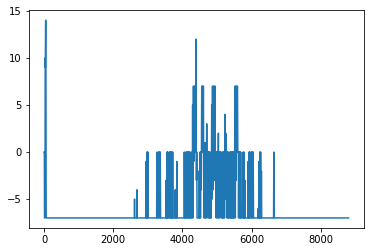

14.0


In [16]:
# Get the building model and specify the .epw
directory = './Building_models/5A_complete_data_sorted/no error/'
filename = 'SF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'#'MF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'
building = ef.get_building(directory + filename)

epw_path = 'GBR_London.Gatwick.037760_IWEC.epw'
    
# Set the cooling setpoint high so that HVAC system is not triggered during heatwave
EPparameters = []
EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                           selector=FieldSelector(class_name='Schedule:Compact',
                                                  object_name='cooling_sch',field_name='Field 4'),
                           value_descriptors=RangeParameter(min_val=20.1,max_val=40)))

# Collect air temperature and humidity as outputs across all zones.
EPobjectives = []
outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
for output in outputs:
    for u in [1,]:
        for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
            EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

# Setting up the EnergyPlus simulation
problem = EPProblem(EPparameters,EPobjectives)
evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

# Running a single simulation with cooling set point specified to be 40°C
results = evaluator.eval_single([40])

# Storing results (living space only)
T = results[0]
TF = T*9/5 + 32
RH = results[3]
# Calculate heat index
HIF = -42.379 + 2.04901523*TF + 10.14333127*RH - .22475541*TF*RH - .00683783*TF*TF \
        - .05481717*RH*RH + .00122874*TF*TF*RH + .00085282*TF*RH*RH - .00000199*TF*TF*RH*RH

HI = (HIF-32)*5/9

# Calculate cumulative0
HI_vals = np.zeros(len(HI))
i = 0
for value in HI:
    if round(value)<27:
        score = -1
    elif round(value)<32:
        score = 0
    elif round(value)<39:
        score = 1
    elif round(value)<52:
        score = 2
    else:
        score = 3

    HI_vals[i] = score
    i = i+1

HW_score = np.zeros(len(HI_vals))
for i in range(len(HI_vals)):
    HW_score[i] = sum(HI_vals[i-7:i])

plt.plot(HW_score)
plt.show()

print(max(HW_score))
